## imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import exp, pi

## Helper functions

### 1. Guassian Blur function


In [2]:
def gaussian_blur(img, kernel_size=5, sigma=0):
    """
    Apply Gaussian blur to an image using a separable 1D Gaussian kernel.
    
    This function implements Gaussian blur by applying two 1D Gaussian kernels
    sequentially (separably) along rows and columns, which is more efficient
    than using a 2D kernel.
    """
    
        # Create Gaussian kernel

    if sigma == 0 :
        sigma = 0.3 * ((kernel_size - 1) * 0.5 - 1) + 0.8
    
    # Create 1D Gaussian kernel
    k = kernel_size // 2
    x = np.arange(-k, k + 1, dtype=np.float32)
    kernel_1d = np.exp(-x**2 / (2 * sigma**2))
    kernel_1d /= kernel_1d.sum()
    
    # Apply 1D kernel along rows and columns (separably)
    blurred = np.apply_along_axis(lambda row: np.convolve(row, kernel_1d, mode='same'), 0, img)
    blurred = np.apply_along_axis(lambda col: np.convolve(col, kernel_1d, mode='same'), 1, blurred)
    
    return blurred.astype(np.uint8)

### 2. CLAHE (Contrast limited Adaptive Histogram Equalization)

In [3]:

def clahe(gray, clip_limit=2.0, tile_grid_size=(8, 8)):
    """Simplified CLAHE using OpenCV.
    Args:
        gray (numpy.ndarray): Input grayscale image
        clip_limit (float): Threshold for contrast limiting. Default is 2.0
        tile_grid_size (tuple): Size of grid for histogram equalization. Default is (8,8)
    
    Returns:
        numpy.ndarray: Contrast enhanced image
    
    """
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(gray)

### 3. MIN_MAX normalization function

In [4]:
def minmax_normalize(channel, min_val=0, max_val=255):
    """
    Normalize an image channel to a specified range using min-max scaling.

    Parameters:
        channel (np.ndarray): Input 2D array (e.g., grayscale image) to normalize.
        min_val (int or float): Desired minimum value after normalization (default: 0).
        max_val (int or float): Desired maximum value after normalization (default: 255).

    Returns:
        np.ndarray: Normalized image with dtype=np.uint8, scaled to [min_val, max_val].
    """
    channel = channel.astype(np.float32)
    c_min, c_max = channel.min(), channel.max()
    
    if c_max == c_min:  # Avoid division by zero (all pixels same value)
        return np.full_like(channel, min_val, dtype=np.uint8)
    
    # Normalize and convert to uint8
    normalized = (channel - c_min) * (max_val - min_val) / (c_max - c_min) + min_val
    return np.clip(normalized, min_val, max_val).astype(np.uint8)

### 4. function to split hsv to h, s, v

In [5]:
def split_hsv(hsv_image):
    """Manually split an HSV image into its H, S, and V channels."""
    h = hsv_image[:, :, 0]
    s = hsv_image[:, :, 1]
    v = hsv_image[:, :, 2]
    return h, s, v



### 5. function to validate a component based on its area

In [6]:
def validate_component(component_stats, min_area=100, max_area=10000):
    """Validate a component based on its properties and relationships."""
    area = component_stats[cv2.CC_STAT_AREA]
    if area < min_area or area > max_area:
        return False
    return True

### 6. function to label signs based on the color and shape

In [7]:

def get_sign_type(num_vertices, color_bgr):
    """
    Determine the type of traffic sign based on its shape (number of vertices)
    and its dominant color (in BGR).

    Shapes:
      - Triangle (3 verts)
      - Rectangle (4 verts)
      - Octagon   (8 verts)
      - Round     (>8 verts)

    Color categories (approximate BGR thresholds):
      - Regulatory: red, white, black
      - Warning:    yellow, orange, fluorescent yellow-green
      - Guide:      green, blue, brown
    """
    b, g, r = color_bgr

    # --- classify shape ---
    if num_vertices == 3:
        shape = 'triangle'
    elif num_vertices == 4:
        shape = 'rectangle'
    elif num_vertices == 8:
        shape = 'octagon'
    elif num_vertices > 8:
        shape = 'round'
    else:
        shape = None

    # --- classify color ---
    if r > 200 and g < 80 and b < 80:
        color_cat = 'red'
    elif r > 200 and g > 200 and b < 80:
        color_cat = 'yellow'
    elif r > 200 and 100 < g < 200 and b < 80:
        color_cat = 'orange'
    elif g > 200 and r > 200 and b < 80:
        color_cat = 'fluorescent'
    elif g > 200 and r < 100 and b < 100:
        color_cat = 'green'
    elif b > 200 and r < 100 and g < 100:
        color_cat = 'blue'
    elif r > 150 and 75 < g < 150 and b < 75:
        color_cat = 'brown'
    elif r > 200 and g > 200 and b > 200:
        color_cat = 'white'
    elif r < 50 and g < 50 and b < 50:
        color_cat = 'black'
    else:
        color_cat = None

    # --- decision logic ---
    # Regulatory: vertical rectangle, octagon, triangle + red/white/black
    if shape in ('triangle','rectangle','octagon') and color_cat in ('red','white','black'):
        return "Regulatory Sign", (0, 0, 255)  # Red outline

    # Warning: diamond (rectangle rotated), pennant (triangle), round 
    #          + yellow/orange/fluorescent
    if shape in ('triangle','rectangle','round') and color_cat in ('yellow','orange','fluorescent'):
        return "Warning Sign", (0, 255, 255)  # Yellow outline

    # Guide: horizontal rectangle + green/blue/brown
    # (we can’t distinguish vertical vs horizontal rect here—assume any rectangle)
    if shape == 'rectangle' and color_cat in ('green','blue','brown'):
        return "Guide Sign", (0, 255, 0)  # Green outline

    # Stop sign override: octagon + red
    if shape == 'octagon' and color_cat == 'red':
        return "Stop Sign", (0, 0, 255)  # Red outline

    # Fallback
    return "Unknown Sign", (255, 255, 255)  # White outline


### 7. function to Normalize HSV values

In [8]:
def normalize_hsv_values(image):
    """Normalize HSV values to handle different lighting conditions."""
    # Split HSV channels
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = split_hsv(hsv_image)
    
    
    # Normalize saturation and value channels
    s = minmax_normalize(s)
    v = minmax_normalize(v)
    
    
    # Merge channels back
    normalized_hsv = cv2.merge([h, s, v])
    return normalized_hsv

### 8. function to analyze shape


In [9]:
def analyze_shape(contour):
    """
    Analyze a contour to determine the number of vertices and its simplified polygonal shape.

    Parameters:
        contour (np.ndarray): A contour (Nx1x2 array) as returned by cv2.findContours().

    Returns:
        tuple:
            - num_vertices (int): Number of vertices in the approximated polygon.
            - approx (np.ndarray): Approximated polygonal curve (simplified shape).
    """
    # Get the perimeter of the contour
    perimeter = cv2.arcLength(contour, True)
    # Approximate the contour to get a simpler shape
    approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
    # Get the number of vertices
    num_vertices = len(approx)
    return num_vertices, approx

## 9. Get Connected Component


In [10]:
def get_connected_components_with_stats(binary_image):
    """
    Manual implementation of cv2.connectedComponentsWithStats function.
    
    Parameters:
    -----------
    binary_image : numpy.ndarray
        Binary input image (0 for background, non-zero for foreground).
        
    Returns:
    --------
    num_labels : int
        The total number of labels including background (label 0).
    labels : numpy.ndarray
        Label matrix where each pixel has the value of its component.
    stats : numpy.ndarray
        Statistics for each label: [left, top, width, height, area].
    centroids : numpy.ndarray
        Centroid coordinates (x, y) for each label.
    """
    # Ensure the input is binary
    binary_image = (binary_image > 0).astype(np.uint8)
    
    # Get image dimensions
    height, width = binary_image.shape
    
    # Initialize labels matrix with zeros (all unassigned)
    labels = np.zeros((height, width), dtype=np.int32)
    
    # Direction arrays for 8-connectivity
    # (x, y) offsets for: top-left, top, top-right, left, right, bottom-left, bottom, bottom-right
    dx = [-1, 0, 1, -1, 1, -1, 0, 1]
    dy = [-1, -1, -1, 0, 0, 1, 1, 1]
    
    # Initialize variables
    current_label = 0  # Start with label 0 (background)
    
    # First pass: Assign preliminary labels
    equiv_table = {}  # Equivalence table for labels
    
    # Process each pixel in the image
    for y in range(height):
        for x in range(width):
            # Skip background pixels
            if binary_image[y, x] == 0:
                continue
                
            # Get neighboring labels (8-connectivity)
            neighbors = []
            for i in range(8):
                nx, ny = x + dx[i], y + dy[i]
                
                # Check bounds
                if nx >= 0 and nx < width and ny >= 0 and ny < height:
                    # If neighbor has a label, add to neighbors list
                    if labels[ny, nx] > 0:
                        neighbors.append(labels[ny, nx])
            
            # If no labeled neighbors, create new label
            if not neighbors:
                current_label += 1
                labels[y, x] = current_label
                equiv_table[current_label] = {current_label}  # New equivalence class
            else:
                # Assign smallest neighbor label
                min_label = min(neighbors)
                labels[y, x] = min_label
                
                # Update equivalence table for all connected labels
                for neighbor_label in neighbors:
                    # Merge equivalence classes
                    equiv_table[min_label] = equiv_table[min_label].union(equiv_table[neighbor_label])
                    for label in equiv_table[neighbor_label]:
                        equiv_table[label] = equiv_table[min_label]
    
    # Resolve equivalences to find final labels
    final_labels = {}
    next_label = 1
    
    # Create a mapping from old labels to final labels
    for label in range(1, current_label + 1):
        if label not in final_labels:
            # Assign a new final label for this equivalence class
            for equiv_label in equiv_table[label]:
                final_labels[equiv_label] = next_label
            next_label += 1
    
    # Second pass: Replace preliminary labels with final labels
    result_labels = np.zeros_like(labels)
    for y in range(height):
        for x in range(width):
            if labels[y, x] > 0:
                result_labels[y, x] = final_labels[labels[y, x]]
    
    # Count the number of labels (including background)
    num_labels = next_label
    
    # Calculate statistics and centroids for each label
    stats = np.zeros((num_labels, 5), dtype=np.int32)
    centroids = np.zeros((num_labels, 2), dtype=np.float64)
    
    # Initialize arrays to track pixel counts for centroid calculation
    pixel_counts = np.zeros(num_labels, dtype=np.int32)
    sum_x = np.zeros(num_labels, dtype=np.float64)
    sum_y = np.zeros(num_labels, dtype=np.float64)
    
    # Initialize bounding box coordinates
    # Initialize with extremes to find min/max later
    left = np.full(num_labels, width, dtype=np.int32)
    top = np.full(num_labels, height, dtype=np.int32)
    right = np.zeros(num_labels, dtype=np.int32)
    bottom = np.zeros(num_labels, dtype=np.int32)
    
    # Gather statistics for each component
    for y in range(height):
        for x in range(width):
            label = result_labels[y, x]
            if label > 0:  # Skip background
                # Update area
                stats[label, 4] += 1  # Area is the 5th column
                
                # Update bounding box
                left[label] = min(left[label], x)
                top[label] = min(top[label], y)
                right[label] = max(right[label], x)
                bottom[label] = max(bottom[label], y)
                
                # Update centroid sums
                sum_x[label] += x
                sum_y[label] += y
                pixel_counts[label] += 1
    
    # Finalize statistics
    for label in range(1, num_labels):
        # Bounding box coordinates
        stats[label, 0] = left[label]  # Left (x)
        stats[label, 1] = top[label]   # Top (y)
        stats[label, 2] = right[label] - left[label] + 1  # Width
        stats[label, 3] = bottom[label] - top[label] + 1  # Height
        
        # Calculate centroids
        if pixel_counts[label] > 0:
            centroids[label, 0] = sum_x[label] / pixel_counts[label]  # x centroid
            centroids[label, 1] = sum_y[label] / pixel_counts[label]  # y centroid
    
    return num_labels, result_labels, stats, centroids


## 10 inrange function


In [11]:
def in_range(image, lower_bound, upper_bound):
    # Ensure inputs are NumPy arrays
    lower_bound = np.array(lower_bound, dtype=np.uint8)
    upper_bound = np.array(upper_bound, dtype=np.uint8)

    # Create mask initialized to all ones (255) then apply conditions
    mask = np.ones(image.shape[:2], dtype=np.uint8) * 255

    for channel in range(image.shape[2]):
        channel_data = image[:, :, channel]
        mask = np.where(
            (channel_data >= lower_bound[channel]) & (channel_data <= upper_bound[channel]),
            mask, 0
        )

    return mask

## bitwise and

In [12]:
def bitwise_and(mask1, mask2):
    # Ensure both masks are of the same shape
    assert mask1.shape == mask2.shape, "Masks must be the same shape"
    return np.where((mask1 > 0) & (mask2 > 0), 255, 0).astype(np.uint8)

## bitwise or

In [13]:
def bitwise_or(mask1, mask2):
    # Ensure both masks are of the same shape
    assert mask1.shape == mask2.shape, "Masks must be the same shape"
    return np.where((mask1 > 0) | (mask2 > 0), 255, 0).astype(np.uint8)

## -----------------------------------------------------------------------

## acquire the image


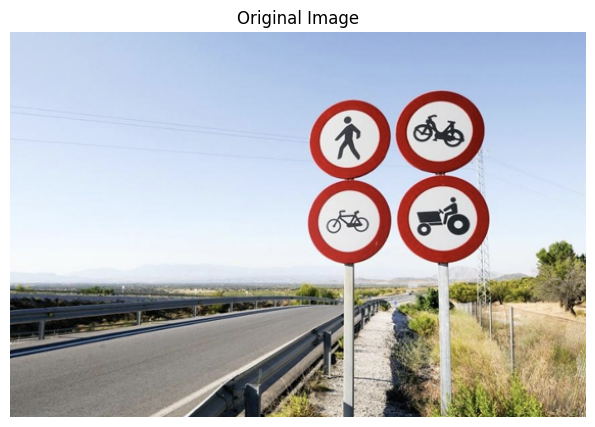

In [14]:
# Read the traffic sign image
image = cv2.imread('assets/traffic_sign.png')

# Check if the image was loaded successfully
if image is None:
    print("Error: Could not read the image")
else:
    # Display the image
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    plt.show()
    

## Convert the Color Space to HSV

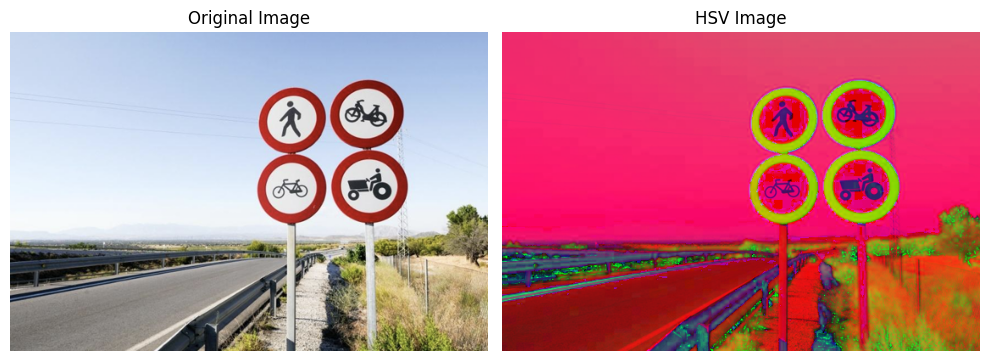

In [15]:
# Convert the image from BGR to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Display both images side by side
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# HSV Image (just for visualization)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(hsv_image, cv2.COLOR_BGR2RGB))
plt.title('HSV Image')
plt.axis('off')

plt.tight_layout()
plt.show()

## Generate Histogram for each HSV Component

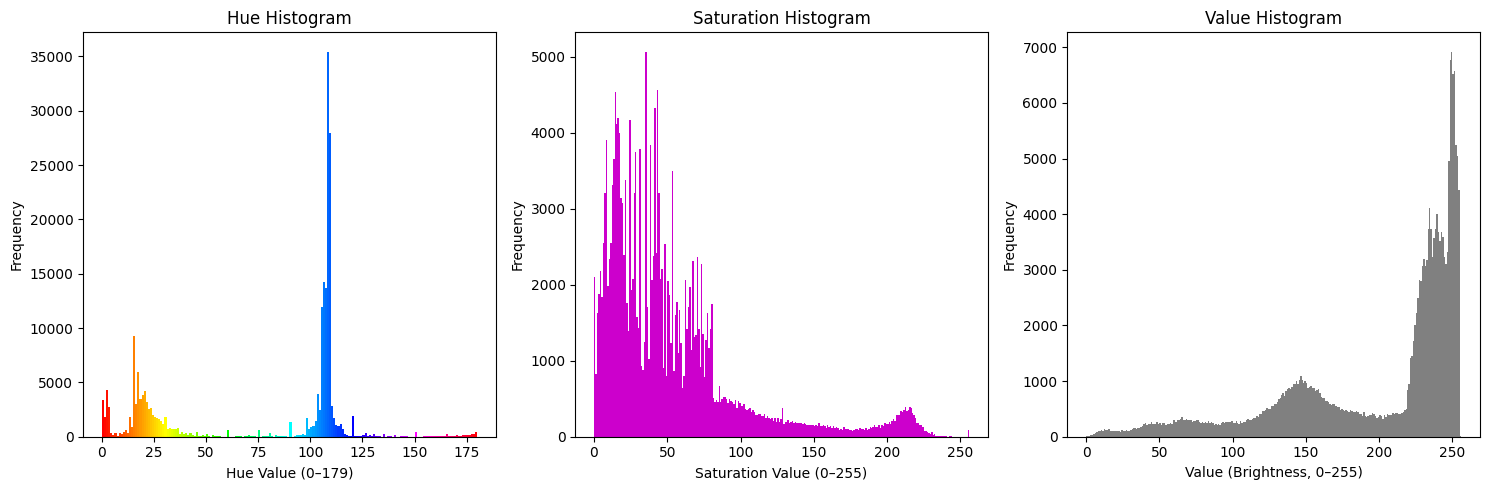

In [16]:
# Split the HSV image into its channels: Hue (H), Saturation (S), and Value (V)
h, s, v = split_hsv(hsv_image)

# Create a figure with 3 horizontal subplots for each channel's histogram
plt.figure(figsize=(15, 5))

# -------------------------------------
# Plot 1: Hue Histogram with HSV-based coloring
# -------------------------------------
plt.subplot(131)
n, bins, patches = plt.hist(h.ravel(), bins=180, range=[0, 180])  # Hue values range from 0 to 179

# Color each histogram bar with its corresponding hue
for c, p in zip(bins, patches):
    # Convert hue to RGB color for visualization
    hue_color = cv2.cvtColor(np.uint8([[[c, 255, 255]]]), cv2.COLOR_HSV2RGB)[0][0] / 255.0
    p.set_facecolor(hue_color)

plt.title('Hue Histogram')
plt.xlabel('Hue Value (0–179)')
plt.ylabel('Frequency')

# -------------------------------------
# Plot 2: Saturation Histogram using a magenta tone
# -------------------------------------
plt.subplot(132)
plt.hist(s.ravel(), bins=256, range=[0, 256], color='#cc00cc')  # Saturation ranges from 0 to 255
plt.title('Saturation Histogram')
plt.xlabel('Saturation Value (0–255)')
plt.ylabel('Frequency')

# -------------------------------------
# Plot 3: Value Histogram using grayscale
# -------------------------------------
plt.subplot(133)
plt.hist(v.ravel(), bins=256, range=[0, 256], color='gray')  # Value ranges from 0 to 255
plt.title('Value Histogram')
plt.xlabel('Value (Brightness, 0–255)')
plt.ylabel('Frequency')

# Adjust spacing between subplots
plt.tight_layout()
# Display all plots
plt.show()


# Preprocess The Traffic Sign Image


function to enhance the input image by making features more distinguishable and reducing noise, which helps in detecting traffic signs more accurately.

In [17]:
def preprocess_image(image, kernel_size=5, clahe_clip=2.0, clahe_grid=(8,8)):
    """Preprocess the BGR image to enhance traffic sign detection in HSV color space."""
    # Convert BGR to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Split channels
    h, s, v = cv2.split(hsv)

    # Apply Gaussian blur to V channel to reduce noise
    v_blurred = gaussian_blur(v, kernel_size=kernel_size)

    # Apply CLAHE to V channel for local contrast enhancement
    v_enhanced = clahe(v_blurred, clip_limit=clahe_clip, tile_grid_size=clahe_grid)

    # Normalize V channel
    v_norm = minmax_normalize(v_enhanced)

    # Merge back channels
    preprocessed_hsv = cv2.merge([h, s, v_norm])

    return preprocessed_hsv

## Create a Trackbar for the user to Choose the Best Thresholds Values

In [18]:
def process_image(image, h_min, h_max, s_min, s_max, v_min, v_max, dilation_size, min_area, max_area):
    """
    Traffic Sign Detection and Classification
    
    This function identifies traffic signs in an HSV image using color filtering, shape analysis, 
    and contour detection techniques. It classifies signs based on their geometric properties.
    
    Parameters:
    -----------
    image : ndarray
        Input image in HSV color space
    h_min, h_max : int
        Lower and upper bounds for Hue channel filtering (0-179)
    s_min, s_max : int
        Lower and upper bounds for Saturation channel filtering (0-255)
    v_min, v_max : int
        Lower and upper bounds for Value channel filtering (0-255)
    dilation_size : int
        Size of the kernel used for morphological dilation
    min_area, max_area : int
        Minimum and maximum area thresholds for valid sign detection
        
    Returns:
    --------
    List[dict]
        List of detected signs, each with:
        - id: Unique identifier
        - type: Sign classification (Warning, Regulatory, Stop, Unknown)
        - vertices: Number of corners detected
        - area: Sign area in pixels
        - position: Bounding box coordinates (x, y, width, height)
        
    Visualizations:
    --------------
    Displays a 3x3 grid of process steps:
    - Original image
    - Initial binary mask from HSV thresholding
    - Dilated mask for component grouping
    - Colored individual components
    - Component spatial relationships
    - Consolidated mask after filtering
    - Final detection with sign classifications
    - Text summary of detections
    - Final binary mask
    """

    # 1. COLOR THRESHOLDING
    # Create HSV threshold boundaries and generate initial binary mask
    lower_bound = np.array([h_min, s_min, v_min])
    upper_bound = np.array([h_max, s_max, v_max])
    mask = in_range(image, lower_bound, upper_bound)

    # 2. MASK CLEANUP
    # Remove noise and fill gaps with morphological operations
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Close small holes

    # 3. CONNECTED COMPONENT ANALYSIS
    # Create dilated mask to help group nearby components
    dilation_kernel = np.ones((dilation_size, dilation_size), np.uint8)
    dilated_mask = cv2.dilate(mask, dilation_kernel, iterations=1)
    
    # Find all connected components in both original and dilated masks
    num_labels, labels, stats, _ = get_connected_components_with_stats(mask)
    num_labels_dilated, labels_dilated, _, _ = get_connected_components_with_stats(dilated_mask)

    # 4. VISUALIZATION PREPARATION
    # Convert HSV image to RGB for display purposes
    rgb_image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    
    # Initialize visualization images
    colored_components = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    relationship_overlay = rgb_image.copy()
    consolidated_mask = np.zeros_like(mask)
    
    # Generate distinct colors for visualizing different components 
    colors = np.random.randint(0, 255, size=(num_labels, 3), dtype=np.uint8)
    colors[0] = [0, 0, 0]  # Background is black

    # 5. COMPONENT ANALYSIS
    # Filter components by size and analyze spatial relationships
    valid_components = []
    for i in range(1, num_labels):
        # Check if component meets size criteria
        if min_area <= stats[i, cv2.CC_STAT_AREA] <= max_area:
            # Extract this component's binary mask
            component_mask = (labels == i).astype(np.uint8)
            
            # Find all dilated components that overlap with this component
            intersections = []
            for j in range(1, num_labels_dilated):
                dilated_component = (labels_dilated == j).astype(np.uint8)
                intersection = bitwise_and(component_mask, dilated_component)
                if np.sum(intersection) > 0:
                    intersections.append(j)
            
            # Keep components that have valid spatial relationships
            if intersections:
                consolidated_mask = bitwise_or(consolidated_mask, component_mask)
                valid_components.append(i)
            
            # Extract component properties
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            area = stats[i, cv2.CC_STAT_AREA]
            
            # Visualize this component
            colored_components[labels == i] = colors[i]
            cv2.rectangle(relationship_overlay, (x, y), (x + w, y + h), colors[i].tolist(), 2)
            cv2.putText(relationship_overlay, f'Area: {area}', (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            
            # Show intersection information if any
            if intersections:
                cv2.putText(relationship_overlay, f'Intersects: {intersections}', (x, y + h + 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # 6. FINAL MASK PREPARATION
    # Clean up the consolidated mask
    consolidated_mask = cv2.morphologyEx(consolidated_mask, cv2.MORPH_CLOSE, kernel)
    
    # Find contours in the final mask for sign detection
    contours, _ = cv2.findContours(consolidated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 7. SIGN DETECTION AND CLASSIFICATION
    final_visualization = rgb_image.copy()
    final_mask = np.zeros_like(consolidated_mask)
    detected_signs = []
    
    for idx, contour in enumerate(contours, 1):
        # Calculate contour area
        area = cv2.contourArea(contour)
        
        # Approximate the shape to determine number of vertices
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        num_vertices = len(approx)
        
        # Classify sign based on number of vertices
        if num_vertices == 3:
            sign_type = "Warning Sign"
            color = (255, 255, 0)  # Yellow
        elif num_vertices == 4:
            sign_type = "Regulatory Sign"
            color = (0, 0, 255)  # Red
        elif num_vertices == 8:
            sign_type = "Stop Sign"
            color = (0, 0, 255)  # Red
        else:
            sign_type = "Unknown Sign"
            color = (0, 255, 0)  # Green
        
        # Draw the sign outline
        cv2.drawContours(final_visualization, [approx], 0, color, 2)
        
        # Get and draw bounding box
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(final_visualization, (x, y), (x + w, y + h), color, 2)
        
        # Label the sign in the visualization
        cv2.putText(final_visualization, f'Sign {idx}: {sign_type}', (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        cv2.putText(final_visualization, f'Vertices: {num_vertices}', (x, y + h + 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # Add to final binary mask
        cv2.drawContours(final_mask, [contour], 0, 255, -1)
        
        # Store sign information in results list
        detected_signs.append({
            'id': idx,
            'type': sign_type,
            'vertices': num_vertices,
            'area': area,
            'position': (x, y, w, h)
        })

    # 8. RESULTS SUMMARY
    # Create text summary of detected signs
    summary_overlay = rgb_image.copy()
    y_offset = 30
    cv2.putText(summary_overlay, f'Detected Signs: {len(detected_signs)}', (10, y_offset),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    for sign in detected_signs:
        y_offset += 30
        cv2.putText(summary_overlay, 
                f"Sign {sign['id']}: {sign['type']} ({sign['vertices']} vertices)",
                (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

    # 9. DISPLAY RESULTS
    # Show all process steps in a grid layout
    plt.figure(figsize=(20, 15))

    plt.subplot(331)
    plt.imshow(rgb_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(332)
    plt.imshow(mask, cmap='gray')
    plt.title('Binary Mask')
    plt.axis('off')

    plt.subplot(333)
    plt.imshow(dilated_mask, cmap='gray')
    plt.title('Dilated Mask')
    plt.axis('off')

    plt.subplot(334)
    plt.imshow(colored_components)
    plt.title('Components')
    plt.axis('off')

    plt.subplot(335)
    plt.imshow(relationship_overlay)
    plt.title('Spatial Relationships')
    plt.axis('off')

    plt.subplot(336)
    plt.imshow(consolidated_mask, cmap='gray')
    plt.title('Consolidated Mask')
    plt.axis('off')

    plt.subplot(337)
    plt.imshow(final_visualization)
    plt.title('Detected Signs')
    plt.axis('off')

    plt.subplot(338)
    plt.imshow(summary_overlay)
    plt.title('Detection Summary')
    plt.axis('off')

    plt.subplot(339)
    plt.imshow(final_mask, cmap='gray')
    plt.title('Final Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 10. PRINT PARAMETER SUMMARY
    print("\nHSV Threshold Values:")
    print(f"Hue: [{h_min}, {h_max}]")
    print(f"Saturation: [{s_min}, {s_max}]")
    print(f"Value: [{v_min}, {v_max}]")
    print(f"Dilation Size: {dilation_size}")
    print(f"Area Range: [{min_area}, {max_area}]")

    # 11. PRINT DETECTION RESULTS
    print("\nDetected Signs Analysis:")
    for sign in detected_signs:
        print(f"\nSign {sign['id']}:")
        print(f"Type: {sign['type']}")
        print(f"Vertices: {sign['vertices']}")
        print(f"Area: {sign['area']:.2f}")
        print(f"Position: {sign['position']}")

    return detected_signs

## Defining the Best Thresholding Parameters

In [19]:
from ipywidgets import interact, fixed, IntSlider
import ipywidgets as widgets
# Define default HSV thresholds
h_min_default = 0
h_max_default = 180
s_min_default = 0
s_max_default = 255
v_min_default = 0
v_max_default = 255
dilation_size_default = 1
min_area_default = 100
max_area_default = 10000

In [20]:
preprocessed_hsv = preprocess_image(image) 
import json
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, fixed

# --- Widgets for HSV thresholding and parameters ---
h_min_slider = widgets.IntSlider(min=0, max=180, step=1, value=h_min_default, description='H min:')
h_max_slider = widgets.IntSlider(min=0, max=180, step=1, value=h_max_default, description='H max:')
s_min_slider = widgets.IntSlider(min=0, max=255, step=1, value=s_min_default, description='S min:')
s_max_slider = widgets.IntSlider(min=0, max=255, step=1, value=s_max_default, description='S max:')
v_min_slider = widgets.IntSlider(min=0, max=255, step=1, value=v_min_default, description='V min:')
v_max_slider = widgets.IntSlider(min=0, max=255, step=1, value=v_max_default, description='V max:')
dilation_slider = widgets.IntSlider(min=1, max=20, step=1, value=dilation_size_default, description='Dilation:')
min_area_slider = widgets.IntSlider(min=10, max=1000, step=10, value=min_area_default, description='Min Area:')
max_area_slider = widgets.IntSlider(min=1000, max=50000, step=1000, value=max_area_default, description='Max Area:')

# --- Interactive process_image call ---
interact(
    process_image,
    image=fixed(preprocessed_hsv),
    h_min=h_min_slider,
    h_max=h_max_slider,
    s_min=s_min_slider,
    s_max=s_max_slider,
    v_min=v_min_slider,
    v_max=v_max_slider,
    dilation_size=dilation_slider,
    min_area=min_area_slider,
    max_area=max_area_slider
)

# --- Button to save current slider values ---
save_button = widgets.Button(description="Save Thresholds")

def save_thresholds(button):
    final_thresholds = {
        'h_min': h_min_slider.value,
        'h_max': h_max_slider.value,
        's_min': s_min_slider.value,
        's_max': s_max_slider.value,
        'v_min': v_min_slider.value,
        'v_max': v_max_slider.value,
        'dilation_size': dilation_slider.value,
        'min_area': min_area_slider.value,
        'max_area': max_area_slider.value
    }
    with open('thresholds.json', 'w') as f:
        json.dump(final_thresholds, f, indent=4)
    print("Thresholds saved to thresholds.json")

save_button.on_click(save_thresholds)
display(save_button)



interactive(children=(IntSlider(value=0, description='H min:', max=180), IntSlider(value=180, description='H m…

Button(description='Save Thresholds', style=ButtonStyle())